### Creating an Epsilon Nearest Neighbors Graph

Imports

#### Import data and basic functions

In [1]:
import glob
import random
import numpy as np
import scipy

In [2]:
SAMPLES = 100
CANCER_TYPES = 10 # How many of the types of cancer should we use
normalize = False
outliers = True
restrictSamples = False # Remove cancer types with less than SAMPLES samples

In [3]:
def generateColors(n):
    """ Generates n random colors in hex """
    
    colorList = []
    possibleValues = list(range(10))+["A","B","C","D","E","F"]
    
    for i in range(n):
        tempColor = "#"
        for j in range(6):
            tempColor+=str(possibleValues[random.randint(0,len(possibleValues)-1)])
        colorList.append(tempColor)
    
    return colorList

def toArray(fileName):
    """Converts exome data to an NP array """
    
    with open(fileName) as f:
        cancerData = f.read().split("\n")[1:-1]
        for i in range(0,len(cancerData)):
            cancerData[i] = cancerData[i].split("\t")[1:]
            cancerData[i] = list(map(int,cancerData[i]))

    cancerData = np.array(cancerData,dtype=np.float).T
    return cancerData

def normalizeRows(mat):
    """ Normalized the rows of the matrix mat """
    
    mat = deepcopy(mat)
    
    for i in range(mat.shape[0]):
        s = sum(mat[i])
        for j in range(mat.shape[1]):
            num = float(mat[i][j])/float(s)
            mat[i][j] = float(mat[i][j])
            mat[i][j]/=float(s)

            mat[i][j] = num

    return mat


In [4]:
#This sections inits all the cancer types 
alexandrovFiles = ["alexandrov_data/breast_exome.txt"]#glob.glob("alexandrov_data/*.txt")

startingPositions = []
allData = np.empty((0,0),dtype=np.float)

if(CANCER_TYPES<len(alexandrovFiles)):
    alexandrovFiles = np.random.choice(alexandrovFiles,CANCER_TYPES,replace=False)
CANCER_TYPES = len(alexandrovFiles)

cancerNames = [i.split("\\")[-1].replace("_","").split("exome")[0] for i in alexandrovFiles]

colors = generateColors(len(cancerNames))
unusedCancers = []

#Combines the data from each of the samples
for i,file in enumerate(alexandrovFiles):
    cancerData = toArray(file)
    sampleRows = cancerData.shape[0]    
    selectedSamples = np.random.choice(sampleRows,min(sampleRows,SAMPLES),replace=False)

    if(sampleRows>=SAMPLES or True):
        if(len(startingPositions)==0):
            startingPositions.append(0)

        startingPositions.append(startingPositions[-1] + min(sampleRows,SAMPLES))


        cancerData = cancerData[selectedSamples]
        
        if(allData.size == 0): 
            allData = cancerData
        else:
            allData = np.append(allData,cancerData,axis=0)
    else:
        unusedCancers.append(i)

cancerNames = [i for j,i in enumerate(cancerNames) if j not in unusedCancers]
CANCER_TYPES = len(cancerNames)


if(normalize):
    allData = normalizeRows(allData)

np.savetxt("allData.csv", allData, delimiter=",")

In [5]:
def findMutationOrder(fileName):
    f = open(fileName).read().split("\n")
    mutationList = []
    for i in f:
        i = i.split(" ")
        for j in i:
            if("[" in j):
                mutationList.append(j.strip("\t").split("\t")[0])
    return mutationList

#### Creating Nearest Neighbor graphs

In [6]:
import scipy.spatial.distance
from pynrnmf import NRNMF
import warnings
warnings.filterwarnings("ignore")

In [7]:
def distanceGraph(mat,epsilon=0.3,metric="Cosine"):
    numRows = mat.shape[0]
    graph = np.zeros((numRows,numRows))
    dist = np.zeros((numRows,numRows))
    for row in range(numRows):
        for otherRow in range(numRows):
            if(otherRow==row):
                dist[row][otherRow] = 10000000
            else:
                if(metric=="Cosine"):
                    dist[row][otherRow] = scipy.spatial.distance.cosine(mat[row],mat[otherRow])
                elif(metric=="Norm"):
                    dist[row][otherRow] = np.linalg.norm(mat[row]-mat[otherRow])
    return dist


def createNearestNeighborEpsilon(mat,epsilon=0.3,metric="Cosine"):
    dist = distanceGraph(mat,epsilon=epsilon,metric=metric)
    numRows = mat.shape[0]
    graph = np.zeros((numRows,numRows))  

    for row in range(numRows):
        for otherRow in range(numRows):
            if(dist[row][otherRow]<=epsilon):
                graph[row][otherRow] = 1
                graph[otherRow][row] = 1
            else:
                graph[row][otherRow] = 0
                graph[otherRow][row] = 0

    return graph

def createNearestNeighbor(mat,k=1,metric="Norm"):
    numRows = mat.shape[0]
    graph = np.zeros((numRows,numRows))
    dist = np.zeros((numRows,numRows))
    for row in range(numRows):
        for otherRow in range(numRows):
            if(otherRow==row):
                dist[row][otherRow] = 10000000
            else:
                if(metric=="Cosine"):
                    dist[row][otherRow] = scipy.spatial.distance.cosine(mat[row],mat[otherRow])#np.linalg.norm(mat[row]-mat[otherRow])
                elif(metric=="Norm"):
                    dist[row][otherRow] = np.linalg.norm(mat[row]-mat[otherRow])
    
    for row in range(numRows):
        smallestNums = np.argpartition(dist[row],k)[:k]
        for i in smallestNums:
            graph[row][i] = 1
            graph[i][row] = 1

    return graph

#### Comparing Factoring Methods 

In [8]:
from sklearn.utils import check_random_state, check_array
from numpy.linalg import norm
import scipy.sparse as sp

def GNMF(X,L,lambd=0,n_components=None,tol=1e-4,max_iter=100,verbose=False):
        n_samples, n_features = X.shape

        if not n_components:
            n_components = n_features
        else:
            n_components = n_components

        #W, H = NBS_init(X,n_components)
        W = np.random.normal(0,1,(n_samples,n_components))**2
        H = np.random.normal(0,1,(n_components,n_features))**2

        reconstruction_err_ = norm(X - np.dot(W, H))
        eps=1e-4#spacing(1) #10e-14
        Lp = (abs(L)+L)/2
        Lm = (abs(L)-L)/2

        for n_iter in range(1, max_iter + 1):
            h1=lambd*np.dot(H,Lm)+np.dot(W.T,(X+eps)/(np.dot(W,H)+eps))
            h2=lambd*np.dot(H,Lp)+np.dot(W.T,np.ones(X.shape))
            H = np.multiply(H,(h1+eps)/(h2+eps))
            H[H<=0]=eps
            H[np.isnan(H)]=eps

            w1=np.dot((X+eps)/(np.dot(W,H)+eps),H.T)
            w2=np.dot(np.ones(X.shape),H.T)
            W = np.multiply(W,(w1+eps)/(w2+eps))
            W[W<=0]=eps
            W[np.isnan(W)]=eps

            if not sp.issparse(X):
                if reconstruction_err_ > norm(X - np.dot(W, H)):
                    H=(1-eps)*H+eps*np.random.normal(0,1,(n_components,n_features))**2
                    W=(1-eps)*W+eps*np.random.normal(0,1,(n_samples,n_components))**2
                reconstruction_err_ = norm(X - np.dot(W, H))
            else:
                norm2X = np.sum(X.data ** 2)  # Ok because X is CSR
                normWHT = np.trace(np.dot(np.dot(H.T, np.dot(W.T, W)), H))
                cross_prod = np.trace(np.dot((X * H.T).T, W))
                reconstruction_err_ = np.sqrt(norm2X + normWHT - 2. * cross_prod)

        return np.squeeze(np.asarray(W)), np.squeeze(np.asarray(H)).T, reconstruction_err_



In [36]:
from sklearn.decomposition import NMF
import time

def getReconstructionErrors(k=5):
    errors = {}
    matrices = factorData(k=k)
    
    for factorMethod in matrices:
        U, V = matrices[factorMethod]
        errors[factorMethod] = np.linalg.norm(allData.T-U.dot(V.T))
    
    return errors

def factorData(k=5,n_inits=100,max_iter=100,n_jobs=1,metric="Cosine"):
    start = time.time()
    returnDict = {}
    
    nn = np.array(createNearestNeighbor(allData,metric=metric))
    nne = np.array(createNearestNeighbor(allData,metric=metric))
    
    """
    model = NRNMF(k=k,W=nn,alpha=10000,init='random',n_inits=n_inits, max_iter=max_iter, n_jobs=n_jobs)
    U, V = model.fit_transform(allData.T)
    returnDict["NN"] = (U,V)
      
      
    model = NRNMF(k=k,W=nn,alpha=0,init='random',n_inits=n_inits, max_iter=max_iter, n_jobs=n_jobs)
    U, V = model.fit_transform(allData.T)
    returnDict["Regular"] = (U,V)
    
    
    model = NRNMF(k=k,W=nne,alpha=10000,init='random',n_inits=n_inits, max_iter=max_iter, n_jobs=n_jobs)
    U, V = model.fit_transform(allData.T)
    returnDict["Epsilon"] = (U,V)
    """    
        
    model = NMF(n_components=k, init='random', random_state=0)
    U = model.fit_transform(allData.T)
    V = model.components_.T
    returnDict["Sklearn"] = (U,V)
    
    
    U,V,r = GNMF(allData.T,nne,0,n_components=k,tol=1e-4,max_iter=max_iter,verbose=False)
    returnDict["Stratipy"] = (U,V)
    
    U,V,r = GNMF(allData.T,nne,0.1,n_components=k,tol=1e-4,max_iter=max_iter,verbose=False)
    returnDict["StratipyGraph0.1"] = (U,V)
    
    U,V,r = GNMF(allData.T,nne,0.25,n_components=k,tol=1e-4,max_iter=max_iter,verbose=False)
    returnDict["StratipyGraph0.25"] = (U,V)
    
    U,V,r = GNMF(allData.T,nne,0.5,n_components=k,tol=1e-4,max_iter=max_iter,verbose=False)
    returnDict["StratipyGraph0.5"] = (U,V)
    
    U,V,r = GNMF(allData.T,nne,10,n_components=k,tol=1e-4,max_iter=max_iter,verbose=False)
    returnDict["StratipyGraph10"] = (U,V)

    finish = time.time() - start
    
    print(k,"took",finish,"seconds")
    
    return returnDict

#### Creating Communities

In [91]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

In [86]:
def communityDetection():
    """ Runs the Classet-Newmann community detection algorithm """
    nn = createNearestNeighbor(allData,k=5,metric="Cosine")
    
    g = nx.Graph()
    for cancer in range(len(cancerNames)):
        for nodeNumber in range(startingPositions[cancer],startingPositions[cancer+1]):
            g.add_node(nodeNumber)

    for i in range(nn.shape[0]):
        for j in range(nn.shape[1]):
            if(nn[i][j]):
                g.add_edge(i,j)

    #Amount of each cancer type in each community
    communities = greedy_modularity_communities(g)
    cancerTypes = []    
    
    for j,community in enumerate(communities):
        tempCancers = {}
        for i in range(1,len(startingPositions)):
            #Num inbetween
            cancersInbetween = len([x for x in community if startingPositions[i-1]<=x<startingPositions[i]])
            tempCancers[cancerNames[i-1]] = cancersInbetween
                    
        cancerTypes.append(tempCancers)

    return cancerTypes

In [87]:
communityDetection()

[{'breast': 288},
 {'breast': 231},
 {'breast': 182},
 {'breast': 92},
 {'breast': 41},
 {'breast': 10}]

#### Running K Means

In [36]:
from scipy.cluster.vq import kmeans2

In [37]:
def runKmeans():
    a = kmeans2(allData,CANCER_TYPES)
    clusterList = a[1]
    clusters = [{} for i in range(CANCER_TYPES)]
    
    for i in range(len(clusters)):
        for j in cancerNames:
            clusters[i][j] = 0
    
    for i in range(len(clusterList)):
        #Find out which type of cancer this is
        cancerType = ""
        for j in range(0,len(startingPositions)-1):
            if(startingPositions[j]<=i<startingPositions[j+1]):
                cancerType = cancerNames[j]
                break
        
        clusters[clusterList[i]][cancerType]+=1

    #Get rid of empty clusters
    clusters = [i for i in clusters if sum(i.values())!=0]
        
    return clusters

In [15]:
runKmeans()

[{'bladder': 16,
  'esophageal': 29,
  'glioma': 30,
  'breast': 29,
  'prostate': 29,
  'adeno': 22,
  'lungsmall': 29,
  'neuroblastoma': 30,
  'glioblastoma': 30,
  'melanoma': 7,
  'clearcell': 30,
  'stomach': 25,
  'uterus': 24,
  'pancreas': 30,
  'thyroid': 30,
  'cervix': 23,
  'papillary': 30,
  'neck': 25,
  'colorectum': 26,
  'lymphoma': 24},
 {'bladder': 4,
  'esophageal': 0,
  'glioma': 0,
  'breast': 0,
  'prostate': 0,
  'adeno': 0,
  'lungsmall': 0,
  'neuroblastoma': 0,
  'glioblastoma': 0,
  'melanoma': 0,
  'clearcell': 0,
  'stomach': 0,
  'uterus': 0,
  'pancreas': 0,
  'thyroid': 0,
  'cervix': 1,
  'papillary': 0,
  'neck': 0,
  'colorectum': 0,
  'lymphoma': 0},
 {'bladder': 0,
  'esophageal': 0,
  'glioma': 0,
  'breast': 0,
  'prostate': 0,
  'adeno': 0,
  'lungsmall': 0,
  'neuroblastoma': 0,
  'glioblastoma': 0,
  'melanoma': 0,
  'clearcell': 0,
  'stomach': 0,
  'uterus': 1,
  'pancreas': 0,
  'thyroid': 0,
  'cervix': 0,
  'papillary': 0,
  'neck': 0,
 

#### Presenting the data from the clusters

In [20]:
import operator
import matplotlib.pyplot as plt

In [40]:
def plotReconstruction(kStart,kEnd,step=1):
    points = []
    types = []
 
    styles = ['r','y','b','g','c','k']

    x = [k for k in range(kStart,kEnd,step)]

    for k in range(kStart,kEnd,step):
        points.append(getReconstructionErrors(k=k))
    
    types = list(points[0].keys())
    scatter = [[] for i in range(len(types))]
    for d in points:
        for i in range(len(types)):
            scatter[i].append(d[types[i]])
            print(types[i],d[types[i]])
    
    for point in range(len(x)-1):
        for type in range(len(types)):
            plt.plot(x[point:point+2], scatter[type][point:point+2], styles[type]+'o-')

    for type in range(len(types)):
        print(types[type],styles[type])
            
    plt.show()
    

5 took 1.775200605392456 seconds
6 took 1.7846918106079102 seconds
7 took 1.8325929641723633 seconds
8 took 1.840651035308838 seconds
9 took 1.8294289112091064 seconds
10 took 1.9326202869415283 seconds
11 took 1.9685258865356445 seconds
12 took 2.031273126602173 seconds
13 took 1.9821252822875977 seconds
14 took 2.055821180343628 seconds
Sklearn 57.106348108228445
Stratipy 66.59356954883701
StratipyGraph0.1 66.52612546103322
StratipyGraph0.25 66.95442466425163
StratipyGraph0.5 66.68170710958896
StratipyGraph10 62.932940850666505
Sklearn 55.0327485448661
Stratipy 61.84994628945839
StratipyGraph0.1 66.080764359714
StratipyGraph0.25 61.36931050580943
StratipyGraph0.5 62.34726105684234
StratipyGraph10 61.20851858057177
Sklearn 53.095997537754165
Stratipy 65.61542712289696
StratipyGraph0.1 62.09002676680062
StratipyGraph0.25 61.91104348983566
StratipyGraph0.5 65.11066211896939
StratipyGraph10 66.85572033049266
Sklearn 51.662212247750396
Stratipy 61.115392429146375
StratipyGraph0.1 61.06314

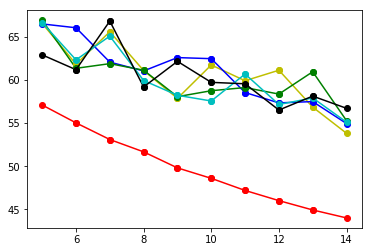

In [41]:
plotReconstruction(5,15)

In [58]:
def presentCSV(clusters):
    csvData = np.zeros(len(clusters),CANCER_TYPES)
    for i in range(len(clusters)):
        for j,cancerName in enumerate(cancerNames):
            csvData[i,j] = clusters[i][cancerName]
    
    csvData = csvData.T
    
    w = open("communityCSV.csv","w")
    for i in range(csvData.shape[0]):
        tempLine = cancerNames[i]+","
        tempLine+=",".join(list(map(str,csvData[i])))
        tempLine+="\n"
        w.write(tempLine)

    w.close()

In [59]:
def printClusters(clusters):
    for i,community in enumerate(clusters):
        sortedCommunity = sorted(community.items(), key=operator.itemgetter(1),reverse=True)  
        print("Community #",(i+1))
        for j in sortedCommunity:
            if(j[1]!=0):
                print(j[0],":",j[1])
        print()

In [96]:
def epsilonConnectedComponents(epsilons):
    scatter = []
    x = epsilons
    
    for epsilon in epsilons:
        nne = createNearestNeighborEpsilon(allData,epsilon=epsilon)
        
        g = nx.Graph()
        for cancer in range(len(cancerNames)):
            for nodeNumber in range(startingPositions[cancer],startingPositions[cancer+1]):
                g.add_node(nodeNumber)

        for i in range(nne.shape[0]):
            for j in range(nne.shape[1]):
                if(nne[i][j]):
                    g.add_edge(i,j)

        connectedComponents = nx.number_connected_components(g)
        scatter.append(connectedComponents)
    
    for point in range(len(scatter)-1):
        plt.plot(x[point:point+2], scatter[point:point+2], 'ro-')

    plt.ylabel("Connected components")
    plt.xlabel("Value of epsilon")
        
    plt.show()

In [60]:
printClusters(runKmeans())

NameError: name 'runKmeans' is not defined

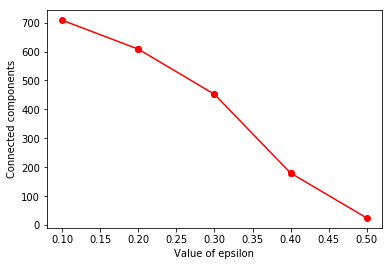

In [97]:
epsilonConnectedComponents([0.1,0.2,0.3,0.4,0.5])

In [43]:
def histogram(v,title):
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    actualCancers = [i for i in list(v.keys()) if v[i]!=0]
    actualValues = [i for i in v.values() if i != 0]
    
    plt.title(title)
    plt.bar(np.arange(len(v.values())), v.values(), align='center', alpha=0.5)
    ax.set_xticklabels(list(v.keys()))
    plt.show()

In [44]:
def cancerHistogram(clusters,cancerName):
    plt.title(cancerName)
    
    values = []
    for i in range(len(clusters)):
        if(cancerName in clusters[i]):
            values.append(clusters[i][cancerName])
        else:
            values.append(0)
    
    plt.bar(np.arange(len(values)),values, align='center', alpha=0.5)
    plt.show()

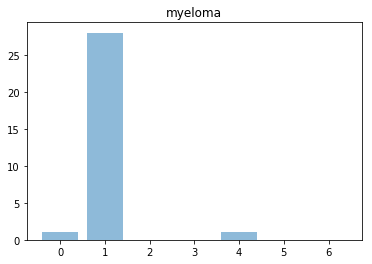

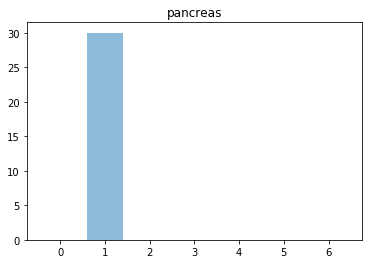

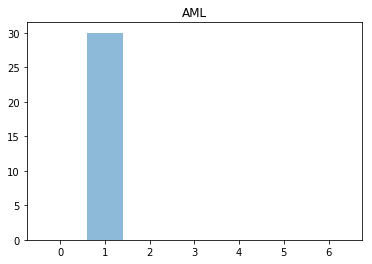

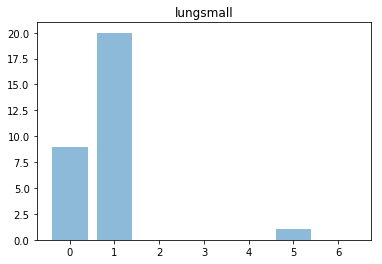

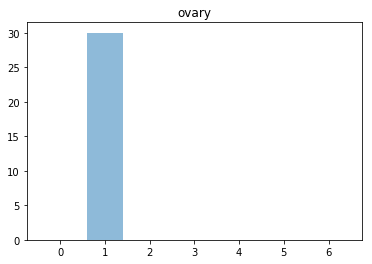

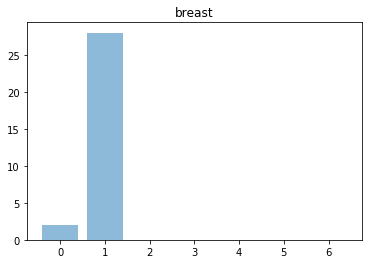

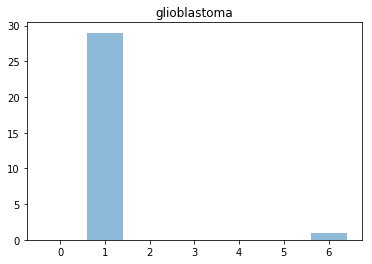

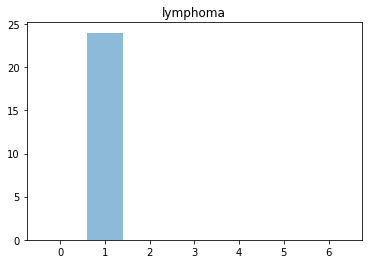

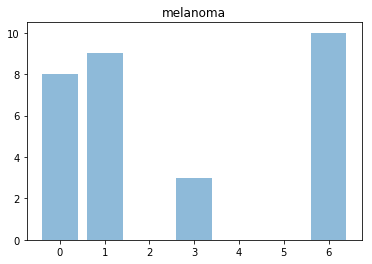

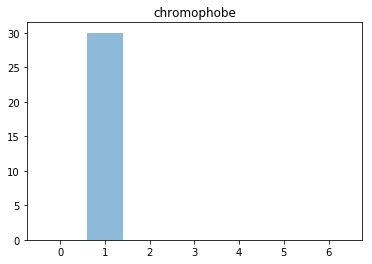

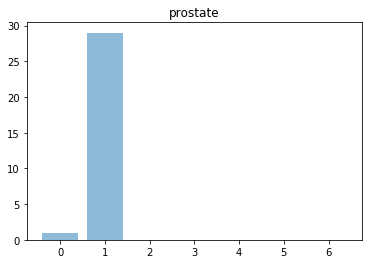

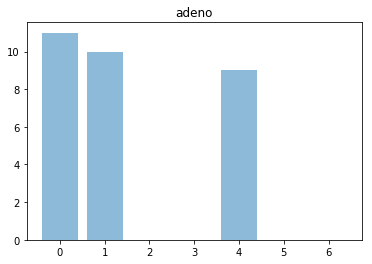

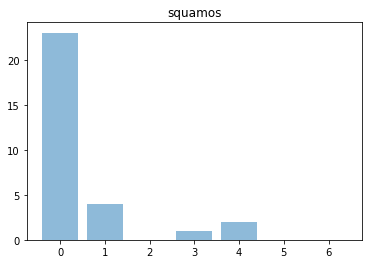

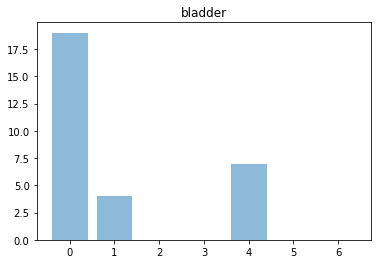

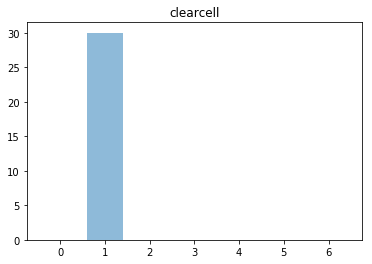

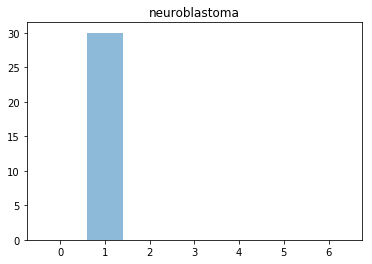

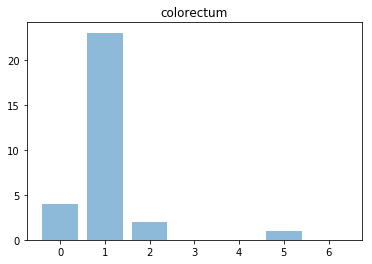

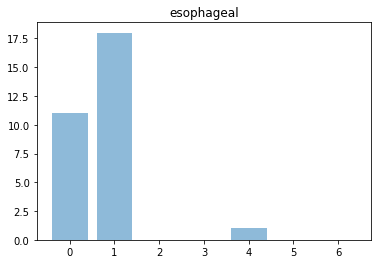

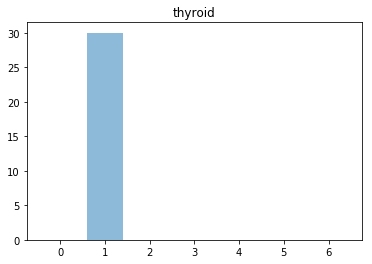

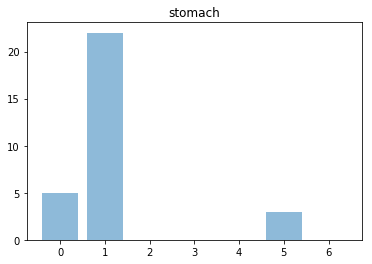

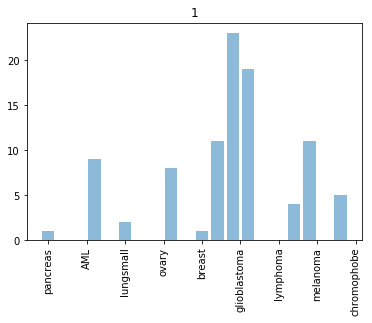

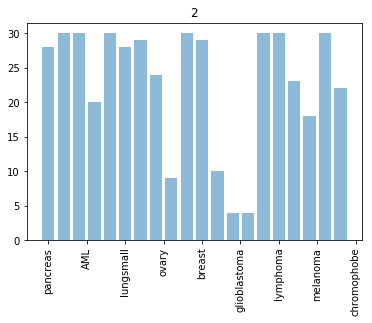

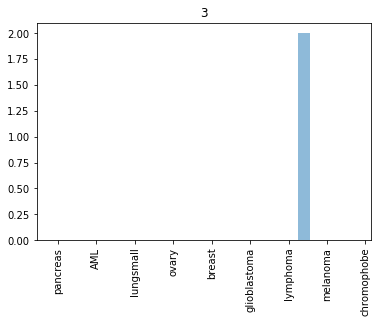

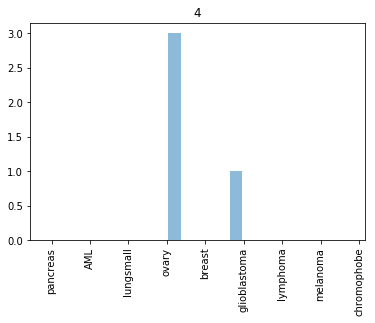

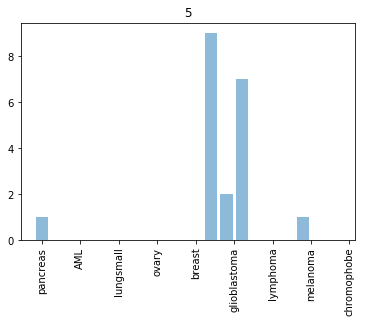

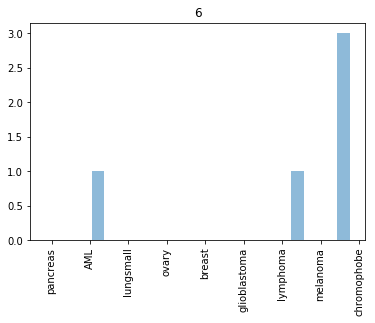

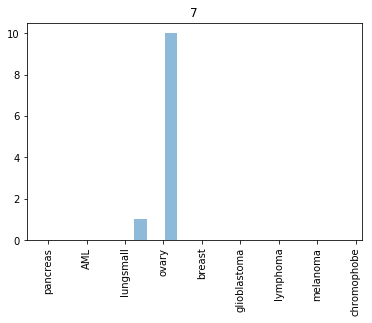

In [46]:
a = runKmeans()
for i in cancerNames:
    cancerHistogram(a,i)

for i in range(len(a)):
    histogram(a[i],str(i+1))

In [14]:
def printHistogram(distanceMatrix):
    flattened = distanceMatrix.flatten()
    plt.hist(flattened,np.arange(0,1,0.1),alpha=0.5, histtype='bar', ec='black')
    plt.title("Distribution of distance values using distance=1-cosine similarity for all pairs of samples")
    plt.show()
    
def inclusionThreshold(nn,threshold):
    return len([i for i in range(len(nn)) if sum(nn[i])<=threshold])

def inclusionThresholdEpsilon(threshold):
    nne = createNearestNeighborEpsilon(allData,epsilon=epsilon)
    return inclusionThreshold(nne,threshold)
    
def numberNodesEpsilon(epsilon):
    nne = createNearestNeighborEpsilon(allData,epsilon=epsilon)
    bins = [0,1,5,10]
    
    binNumbers = [0 for i in range(len(bins))]
    
    for i in range(len(bins)):
        binNumbers[i] = inclusionThreshold(nne,bins[i])
        if(i != 0):
            binNumbers[i]-=sum(binNumbers[0:i])
    binNumbers.append(nne.shape[0]-sum(binNumbers))
    
    plt.title(str(bins))
    plt.bar(np.arange(len(binNumbers)),binNumbers, align='center', alpha=0.5)
    plt.show()
    
    return binNumbers[0]

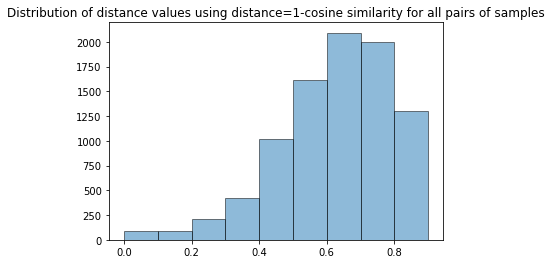

In [45]:
printHistogram(distanceGraph(allData))

In [27]:
distanceGraph(allData).shape

(594, 594)

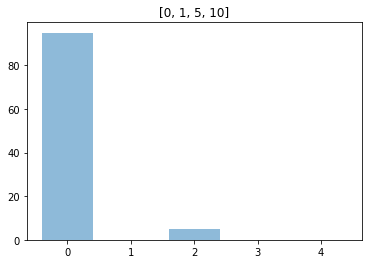

1 95


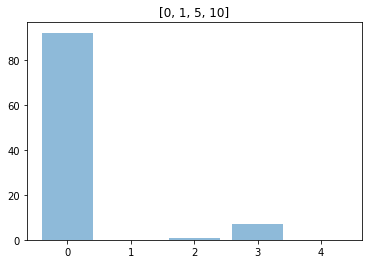

2 92


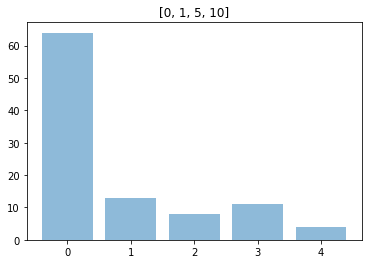

3 64


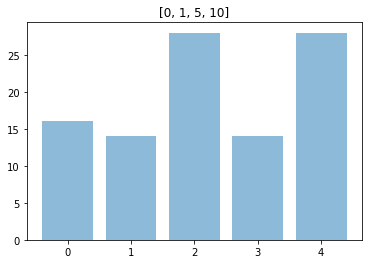

4 16


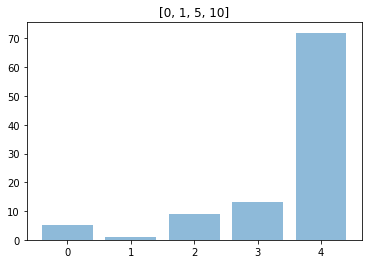

5 5


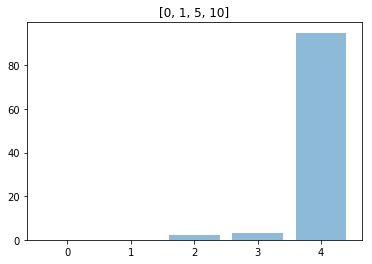

6 0


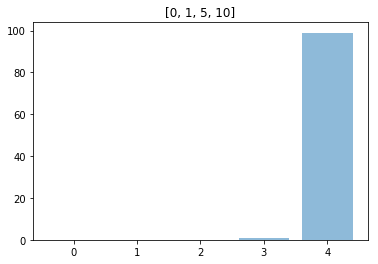

7 0


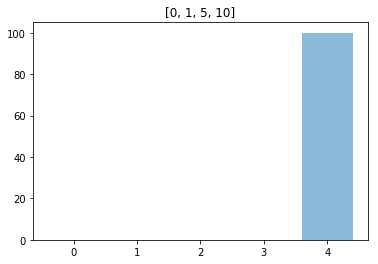

8 0


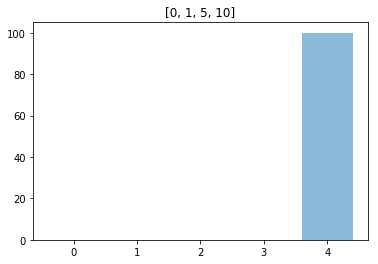

9 0


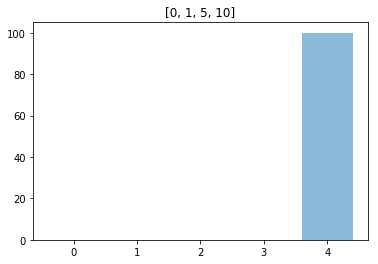

10 0


In [16]:
for i in range(1,11):
    print(i,numberNodesEpsilon(i/10))

In [12]:
import scipy.optimize

In [13]:
def findSignatures(fileName):
    f = open(fileName).read().split("\n")[1:]
    for i in range(len(f)):
        f[i] = f[i].split(" ")[3:]
        f[i] = list(map(float,f[i]))
    f = np.array(f).T
    return f

def findBreastSignatures():
    signatureNumbers = [1,2,3,5,6,8,10,13,17,18,20,26,30]
    signatureNumbers = [i-1 for i in signatureNumbers]
    fileName = "signatures.txt"
    
    return findSignatures(fileName)[signatureNumbers,:]

In [14]:
def cosineTable(a,b):
    """Show Best runs the Hungarian algorithm to determine the best matching"""

    print(len(b),len(a))
    similarities = [[scipy.spatial.distance.cosine(a[i],b[j]) for j in range(len(b))] for i in range(len(a))]
    similarities = np.array(similarities)
    numSignatures = len(similarities)

    s = 0

    row,col = scipy.optimize.linear_sum_assignment(similarities)
    best = [[False for i in range(numSignatures)] for j in range(numSignatures)]

    for i in range(len(row)):
        s+=similarities[row[i],col[i]]
        best[row[i]][col[i]] = True

    #similarities[np.logical_not(best)] = 0

    fig = plt.figure()
    ax = fig.add_subplot(111)
    m = ax.matshow(similarities)
    fig.colorbar(m)

    plt.ylabel("My Signature")
    plt.xlabel("Actual signature")
    ax.set_xticklabels(['']+list(range(1,numSignatures+1)))
    ax.set_yticklabels(['']+list(range(1,numSignatures+1)))

    return s/numSignatures


In [33]:
ourSignatures = factorData(k=13)['StratipyGraph0.25'][0].T

13 took 1.8832950592041016 seconds


In [34]:
theirSignatures = findBreastSignatures()

13 13


0.44030263408757225

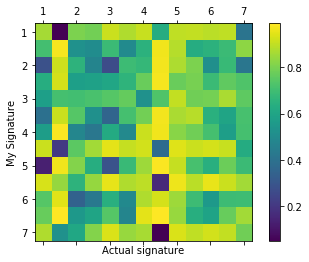

In [35]:
cosineTable(ourSignatures,theirSignatures)

In [29]:
def similarity(signatureOne,signatureTwo):
    dist = np.zeros((signatureOne.shape[0],signatureTwo.shape[0]))
    for i in range(signatureOne.shape[0]):
        for j in range(signatureTwo.shape[0]):
            dist[i,j] = scipy.spatial.distance.cosine(signatureOne[i],signatureTwo[j])
    
    row, col = scipy.optimize.linear_sum_assignment(dist)
    score = dist[row,col].sum()/(signatureOne.shape[0])
    return 1-score
            

In [30]:
similarity(ourSignatures[0].T,theirSignatures)

ValueError: matrix contains invalid numeric entries

In [32]:
theirSignatures

array([[1.10983262e-02, 9.14934073e-03, 1.49007047e-03, ...,
        1.29173698e-03, 2.03107688e-03, 4.03012816e-03],
       [6.82708227e-04, 6.19107232e-04, 9.92789560e-05, ...,
        1.42814560e-05, 2.06615168e-04, 2.35982040e-05],
       [2.21723068e-02, 1.78716754e-02, 2.13833962e-03, ...,
        6.16025042e-03, 1.10765263e-02, 1.30009842e-02],
       ...,
       [1.17996160e-03, 2.21150515e-03, 1.61691000e-07, ...,
        3.77234437e-04, 5.15421599e-04, 6.15656691e-04],
       [2.03977291e-03, 1.48716228e-03, 2.83945614e-04, ...,
        2.71850985e-03, 1.36916117e-03, 2.56807673e-03],
       [0.00000000e+00, 0.00000000e+00, 1.96730000e-03, ...,
        4.32820000e-03, 8.26280000e-03, 0.00000000e+00]])